# **A notebook implementing the AlexNet from Scratch**

**Imports the required Libraries**

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time 

**Loading Cifar-10 Dataset using Keras dataset library**

In [6]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


**Classes which we are going to predit in an image**

In [7]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**Create a Validation set from the first 5000 training images and labels**

In [8]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]

#Remaining images and labels from total of 60K will be assigned to training set
train_images, train_labels = train_images[5000:], train_labels[5000:]


**Converting Training/Validation/Test set into dataset that can be used in tensorflow model training**

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images,validation_labels))

**Visualizing the dataset**

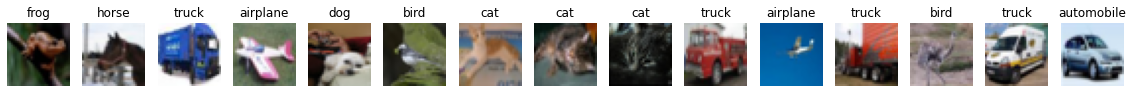

In [10]:
plt.figure(figsize = (20,20))
for i,(image,label) in enumerate(train_ds.take(15)):
  ax = plt.subplot(5,15,i+1)
  plt.imshow(image)
  plt.title(CLASS_NAMES[label.numpy()[0]])
  plt.axis('off')

**Preprocessing**

In [11]:
def process_images(image,label):
  #Normalize: Mean = 0, Std = 1
  image = tf.image.per_image_standardization(image)
  
  #Resize the image from 32x32 to 227x227 for standard required input of AlexNet
  image = tf.image.resize(image, (227,227))

  return image,label

**Get the size of the train/test/validation set**

In [12]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print(train_ds_size)
print(test_ds_size)
print(validation_ds_size)


45000
10000
5000


**Reszing and creating Batch sizes and shuffling the dataset**

In [13]:
train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size= train_ds_size)
            .batch(batch_size=32, drop_remainder = True))

test_ds = (test_ds
            .map(process_images)
            .shuffle(buffer_size= test_ds_size)
            .batch(batch_size=32, drop_remainder = True))
validation_ds = (validation_ds
            .map(process_images)
            .shuffle(buffer_size= validation_ds_size)
            .batch(batch_size=32, drop_remainder = True))


**Creating the AlexNet model Architecture**

In [14]:
from matplotlib.cbook import flatten
model = keras.models.Sequential([
          
          #Convolutional Layers
          keras.layers.Conv2D(filters=96, kernel_size = (11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides = (2,2)),

          keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

          keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),

          keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),

          keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

          #Fully Connected Layers
          keras.layers.Flatten(),
          keras.layers.Dense(4096, activation='relu'),
          keras.layers.Dropout(0.5),

          keras.layers.Dense(4096, activation='relu'),
          keras.layers.Dropout(0.5),
          
          #Softmax Layer to define which class has highest probability
          keras.layers.Dense(10, activation='softmax')
                               
])

**To check the Logs while training data**

In [15]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

**Defining Loss function, optimizer, and display Model summary**

In [16]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


**Training the Model**

In [17]:
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/50
1406/1406 [==============================] - 760s 533ms/step - loss: 2.0458 - accuracy: 0.3521 - val_loss: 1.3504 - val_accuracy: 0.5192
Epoch 2/50
1406/1406 [==============================] - 749s 532ms/step - loss: 1.4841 - accuracy: 0.4755 - val_loss: 1.2041 - val_accuracy: 0.5787
Epoch 3/50
1406/1406 [==============================] - 740s 525ms/step - loss: 1.2979 - accuracy: 0.5410 - val_loss: 1.0888 - val_accuracy: 0.6202
Epoch 4/50
1406/1406 [==============================] - 747s 531ms/step - loss: 1.1770 - accuracy: 0.5843 - val_loss: 0.9983 - val_accuracy: 0.6488
Epoch 5/50
1406/1406 [==============================] - 742s 527ms/step - loss: 1.0710 - accuracy: 0.6210 - val_loss: 0.9173 - val_accuracy: 0.6795
Epoch 6/50
1406/1406 [==============================] - 744s 529ms/step - loss: 0.9868 - accuracy: 0.6521 - val_loss: 0.8685 - val_accuracy: 0.6881
Epoch 7/50
1406/1406 [==============================] - 754s 535ms/step - loss: 0.9132 - accuracy: 0.6765 - val_

**Test the Model's accuracy**

In [18]:
model.evaluate(test_ds)

312/312 [==============================] - 27s 86ms/step - loss: 0.8405 - accuracy: 0.8060


[0.8405038118362427, 0.8059895634651184]